In [178]:
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split, StratifiedKFold
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2, style="ticks")
%matplotlib inline

# Problem 1: Dataset Import & Cleaning
Check **"Profit"** and **"Sales"** in the dataset, convert these two columns to numeric type.  

In [2]:
# Read the two datasets
orders = pd.read_csv('data/Orders.csv')
returns = pd.read_csv('data/Returns.csv')

In [3]:
# remove periods from orders column names
orders.columns=orders.columns.str.replace('.','_')
# remove spaces from region column names
returns.columns=returns.columns.str.replace(' ','_')

In [4]:
orders.Profit = orders.Profit.apply(lambda s: float(s.replace("$","").replace(',','')))
orders.Sales = orders.Sales.apply(lambda s: float(s.replace("$","").replace(',','')))

In [5]:
# How much data is there?
print("Orders dimensions:", orders.shape,"\n")
# How many null values are there - we see that there are 41,296 missing postcodes
print("Missing values:\n",orders.isnull().sum())

Orders dimensions: (51290, 24) 

Missing values:
 Row_ID                0
Order_ID              0
Order_Date            0
Ship_Date             0
Ship_Mode             0
Customer_ID           0
Customer_Name         0
Segment               0
Postal_Code       41296
City                  0
State                 0
Country               0
Region                0
Market                0
Product_ID            0
Category              0
Sub_Category          0
Product_Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping_Cost         0
Order_Priority        0
dtype: int64


In [6]:
# Take a look at the first few rows of orders
orders.head()

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Postal_Code,City,...,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority
0,40098,CA-2014-AB10015140-41954,11/11/14,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,...,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High
1,26341,IN-2014-JR162107-41675,2/5/14,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,...,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical
2,25330,IN-2014-CR127307-41929,10/17/14,10/18/14,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,...,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium
3,13524,ES-2014-KM1637548-41667,1/28/14,1/30/14,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,...,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium
4,47221,SG-2014-RH9495111-41948,11/5/14,11/6/14,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,...,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical


In [7]:
# Take a look at the first few rows of returns
returns.head()

,Returned,Order_ID,Region
0,Yes,CA-2012-SA20830140-41210,Central US
1,Yes,IN-2012-PB19210127-41259,Eastern Asia
2,Yes,CA-2012-SC20095140-41174,Central US
3,Yes,IN-2015-JH158207-42140,Oceania
4,Yes,IN-2014-LC168857-41747,Oceania


# Problem 2: Inventory Management
- Retailers that depend on seasonal shoppers have a particularly challenging job when it comes to 
  inventory management. Your manager is making plans for next year's inventory.
- He wants you to answer the following questions:
    1. Is there any seasonal trend of inventory in the company?
    2. Is the seasonal trend the same for different categories?

In [8]:
# Check data type for Order Date
orders.Order_Date.apply(type)[:1]

0    <class 'str'>
Name: Order_Date, dtype: object

In [9]:
# First convert Order_Date to type datetime
orders.Order_Date = pd.to_datetime(orders.Order_Date)

# What range of time is covered?
print("Start: %s" % max(orders.Order_Date))
print("End: %s" % min(orders.Order_Date))

Start: 2015-12-31 00:00:00
End: 2012-01-01 00:00:00


In [10]:
# Get a sum of orders per day
quantity_by_date = orders[["Order_Date","Quantity"]].groupby(["Order_Date"]).sum()
quantity_by_date = quantity_by_date.groupby(pd.Grouper(freq="M")).sum()
quantity_by_date.reset_index(level=0, inplace=True)
quantity_by_date.head()

,Order_Date,Quantity
0,2012-01-31,1463
1,2012-02-29,1401
2,2012-03-31,1745
3,2012-04-30,1934
4,2012-05-31,2167


[Text(0,0.5,'Quantity'),
 Text(0.5,0,'Order Date'),
 Text(0.5,1,'Total Order Quantity by Date')]

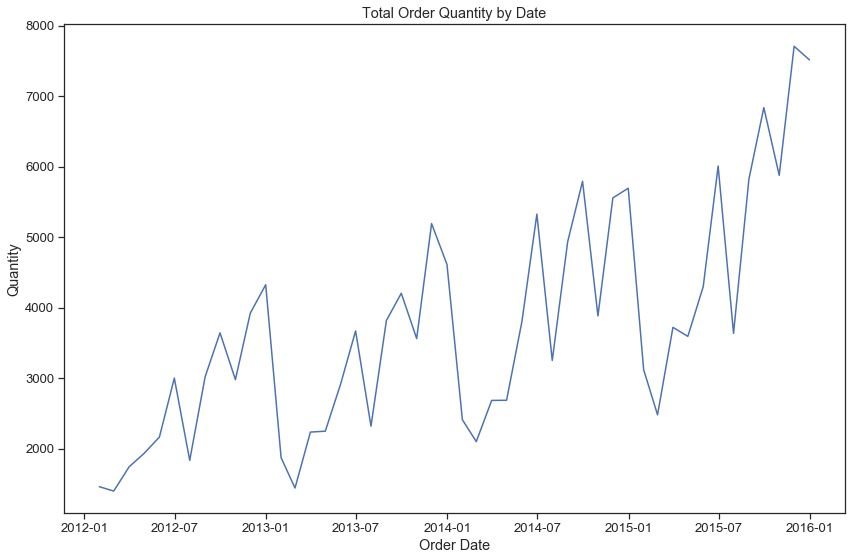

In [11]:
# PLOT!
plt.rcParams['figure.figsize'] = 14, 9 # make the figure wider than the default
g = sns.lineplot(x = quantity_by_date.Order_Date, y = quantity_by_date.Quantity)
g.set(xlabel='Order Date', ylabel='Quantity', title = "Total Order Quantity by Date")

In [12]:
# Also group by category
quant_cat = orders[["Category","Order_Date","Quantity"]].groupby(["Order_Date","Category"]).sum()
quant_cat = quant_cat.reset_index(level=["Category"])

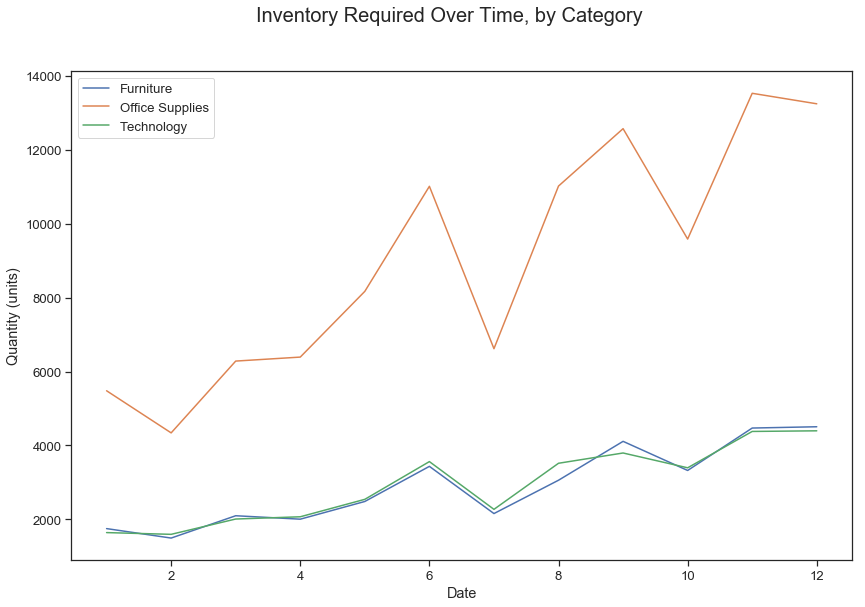

In [13]:
# PLOT!
quant_cat_plot = quant_cat.groupby([quant_cat.index.month, 
                                    'Category']).sum().unstack(fill_value=0).plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Quantity (units)')
plt.suptitle('Inventory Required Over Time, by Category', fontsize=20)
L=plt.legend()
L.get_texts()[0].set_text('Furniture')
L.get_texts()[1].set_text('Office Supplies')
L.get_texts()[2].set_text('Technology')

### Seasonal trends
It appears that orders spike in the start of summer(June), start of the school year (August, September), and Holiday season (November, December).

# Problem 3: Why did customers make returns?
Your manager required you to give a brief report (**Plots + Interpretations**) on returned orders.

1. How much profit did we lose due to returns each year?
2. How many customer returned more than once? more than 5 times?
3. Which regions are more likely to return orders?
4. Which categories (sub-categories) of products are more likely to be returned?

***Hint:*** Merge the **Returns** dataframe with the **Orders** dataframe using `Order.ID`.

In [14]:
# How much profit was lost to returns?
# Add returned column to orders
r2 = returns.drop(columns="Region")
merged = orders.merge(r2,left_on="Order_ID", right_on="Order_ID", how="left")

# Replace NaN with "No"
merged.Returned = merged.Returned.replace(np.nan, 'No', regex=True)
merged.Returned.unique()

# Get the profit returned and not returned
merged['Year'] = merged.Order_Date.apply(lambda d: d.year)
merged2 = merged[["Year","Returned","Profit"]].groupby(["Year","Returned"]).sum()
merged2 = merged2.reset_index(level=["Returned"])
# merged2

In [15]:
# To view as pcts, get the total profit
total_profit = merged2.groupby("Year").sum()
total_profit=total_profit.rename(columns = {'Profit':'Year_Total_Profit'})
merged3 = merged2.merge(total_profit,left_on="Year", right_on="Year", how="left")
merged3["Pct_Year_Total_Profit"] = merged3.Profit / merged3.Year_Total_Profit * 100
# merged3

In [16]:
# Profits lost each year
# merged3.loc[merged3.Returned=="Yes"].iloc[:,[0,2,3]]

In [17]:
# How many customers returned an item more than once?
repeat_off = merged.loc[(merged.Returned=="Yes")].groupby("Customer_ID").size()
repeat_off[repeat_off > 1].size

547

In [18]:
# Made more than 5 returns
repeat_off[repeat_off > 5].size

46

In [19]:
# Which regions are more likely to return orders
ret = merged[["Region","Returned","Order_ID"]].groupby(["Region","Returned"]).count()
ret = ret.reset_index(level=["Returned"])
ret = ret.rename(columns = {"Order_ID":"Order_Count"})

# get total # of returns
total_ret = ret.groupby("Region").sum()
total_ret=total_ret.rename(columns = {'Order_Count':'Total_Orders'})

# merge total # of returns and get percents
ret = ret.merge(total_ret,left_on="Region", right_on="Region", how="left")
ret = ret.loc[ret.Returned == "Yes"]
ret = ret.rename(columns = {"Order_Count":"Returned_Orders"})
ret["Pct_Returned"] = ret.Returned_Orders / ret.Total_Orders * 100
# ret.iloc[:,1:4].sort_values(by="Pct_Returned", ascending = False)

In [20]:
# Which categories (sub-categories) of products are more likely to be returned
ret_cat = merged[["Category","Sub_Category","Returned","Order_ID"]].groupby(["Category","Sub_Category",
                                                                             "Returned"]).count()
ret_cat = ret_cat.reset_index(level=["Returned"])
ret_cat = ret_cat.reset_index(level=["Category"])
ret_cat = ret_cat.rename(columns = {"Order_ID":"Order_Count"})

total_ret_cat = ret_cat.groupby(["Sub_Category"]).sum()
total_ret_cat = total_ret_cat.rename(columns = {'Order_Count':'Total_Orders_Sub_Cat'})
total_ret_cat = total_ret_cat.reset_index(level=["Sub_Category"])
# total_ret_cat

ret_cat = ret_cat.merge(total_ret_cat,left_on="Sub_Category", right_on="Sub_Category", how="left")
ret_cat = ret_cat.loc[ret_cat.Returned == "Yes"]
ret_cat = ret_cat.rename(columns = {"Order_Count":"Returned_Orders_Sub_Cat"})
ret_cat["Pct_Returned_Sub_Cat"] = ret_cat.Returned_Orders_Sub_Cat / ret_cat.Total_Orders_Sub_Cat * 100
ret_cat = ret_cat[["Category","Sub_Category","Returned_Orders_Sub_Cat","Total_Orders_Sub_Cat","Pct_Returned_Sub_Cat"]]
# ret_cat.sort_values(by="Pct_Returned_Sub_Cat", ascending = False)

## Problem 3 Summary

### Profits lost each year

In [21]:
pft_lost_ret_yearly = merged3.loc[merged3.Returned=="Yes"].iloc[:,[0,2,3]]
pft_lost_ret_yearly

,Returned,Year_Total_Profit,Pct_Year_Total_Profit
Year,,,
2012,Yes,248940.35,7.020662
2013,Yes,307415.33,3.015429
2014,Yes,406934.89,4.303054
2015,Yes,504166.10,3.394312


[Text(0,0.5,'Percent of Total Profit Lost to Returns'),
 Text(0.5,0,'Year'),
 Text(0.5,1,'Yearly Percent of Total Profit Lost to Returns')]

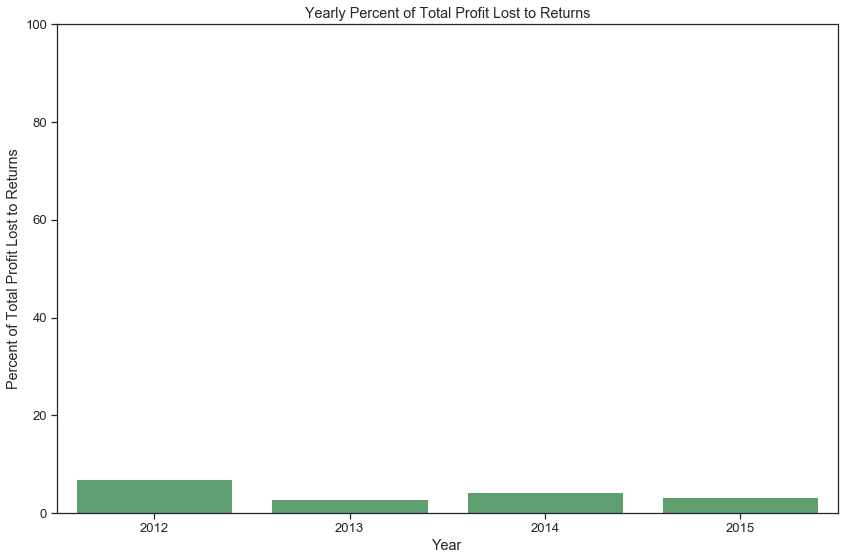

In [22]:
g3_1 = sns.barplot(x = pft_lost_ret_yearly.index, y = pft_lost_ret_yearly.Pct_Year_Total_Profit, color='g')
g3_1.set(ylim=(0, 100))
g3_1.set(xlabel='Year', ylabel='Percent of Total Profit Lost to Returns', 
        title = "Yearly Percent of Total Profit Lost to Returns")

### Customer Returns

* 547 customers returned more than once
* 46  customers returned more than 5x

### Returns by Region

* The Western US, Eastern Asia, Southern Europe, Southern Africa, and Southern US are the top 5 most likely regions to return.  All had a return percentage of greater than 5%.

In [23]:
p3_3 = ret.iloc[:,1:4].sort_values(by="Pct_Returned", ascending = False)
p3_3

,Returned_Orders,Total_Orders,Pct_Returned
Region,,,
Western US,177,3203,5.526069
Eastern Asia,131,2374,5.518113
Southern Europe,112,2113,5.300521
Southern Africa,25,478,5.230126
Southern US,83,1620,5.123457
Eastern US,134,2848,4.705056
Southeastern Asia,140,3129,4.474273
South America,133,2988,4.451138
Western Asia,108,2440,4.426230


[Text(0,0,'Western US'),
 Text(0,0,'Eastern Asia'),
 Text(0,0,'Southern Europe'),
 Text(0,0,'Southern Africa'),
 Text(0,0,'Southern US'),
 Text(0,0,'Eastern US'),
 Text(0,0,'Southeastern Asia'),
 Text(0,0,'South America'),
 Text(0,0,'Western Asia'),
 Text(0,0,'Oceania'),
 Text(0,0,'Central America'),
 Text(0,0,'Southern Asia'),
 Text(0,0,'Central Asia'),
 Text(0,0,'Western Africa'),
 Text(0,0,'Caribbean'),
 Text(0,0,'North Africa'),
 Text(0,0,'Western Europe'),
 Text(0,0,'Canada'),
 Text(0,0,'Northern Europe'),
 Text(0,0,'Central US'),
 Text(0,0,'Eastern Europe'),
 Text(0,0,'Central Africa'),
 Text(0,0,'Eastern Africa')]

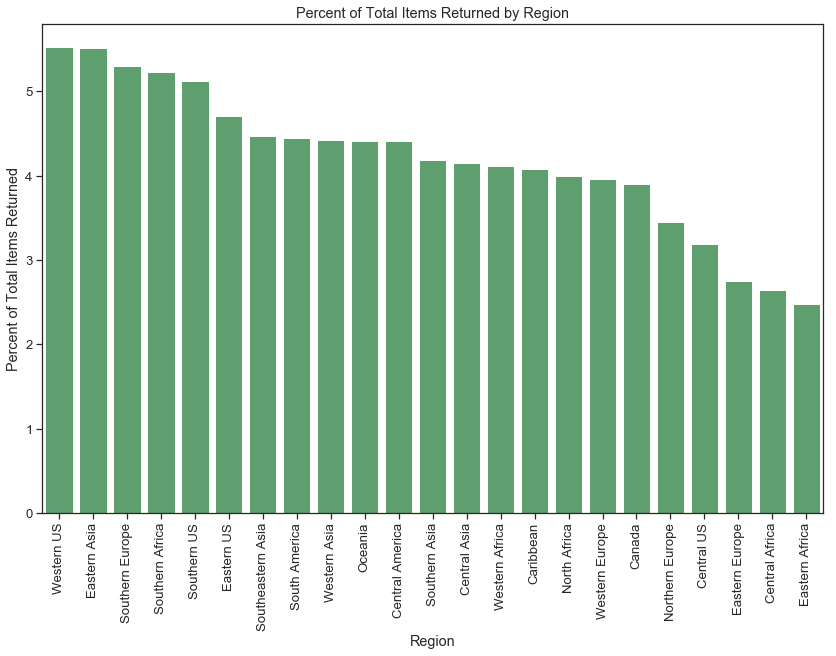

In [24]:
g3_3 = sns.barplot(x = p3_3.index, y = p3_3.Pct_Returned, color='g')
g3_3.set(xlabel='Region', ylabel='Percent of Total Items Returned', 
        title = "Percent of Total Items Returned by Region")
g3_3.set_xticklabels(rotation=90, labels = p3_3.index)

### Returns by Category

* Labels and Tables are the most likely sub-categories to be returned.
* All three super-categories were equally likely to be returned

In [25]:
p3_4_sub = ret_cat.sort_values(by="Pct_Returned_Sub_Cat", ascending = False)
p3_4_sub

,Category,Sub_Category,Returned_Orders_Sub_Cat,Total_Orders_Sub_Cat,Pct_Returned_Sub_Cat
19,Office Supplies,Labels,137,2601,5.267205
7,Furniture,Tables,41,861,4.761905
27,Technology,Accessories,138,3075,4.487805
11,Office Supplies,Art,217,4864,4.461349
29,Technology,Copiers,99,2223,4.453441
13,Office Supplies,Binders,269,6146,4.376830
33,Technology,Phones,145,3357,4.319333
1,Furniture,Bookcases,104,2411,4.313563
21,Office Supplies,Paper,150,3492,4.295533
3,Furniture,Chairs,147,3434,4.280722


[Text(0,0,'Labels'),
 Text(0,0,'Tables'),
 Text(0,0,'Accessories'),
 Text(0,0,'Art'),
 Text(0,0,'Copiers'),
 Text(0,0,'Binders'),
 Text(0,0,'Phones'),
 Text(0,0,'Bookcases'),
 Text(0,0,'Paper'),
 Text(0,0,'Chairs'),
 Text(0,0,'Furnishings'),
 Text(0,0,'Supplies'),
 Text(0,0,'Machines'),
 Text(0,0,'Storage'),
 Text(0,0,'Envelopes'),
 Text(0,0,'Fasteners'),
 Text(0,0,'Appliances')]

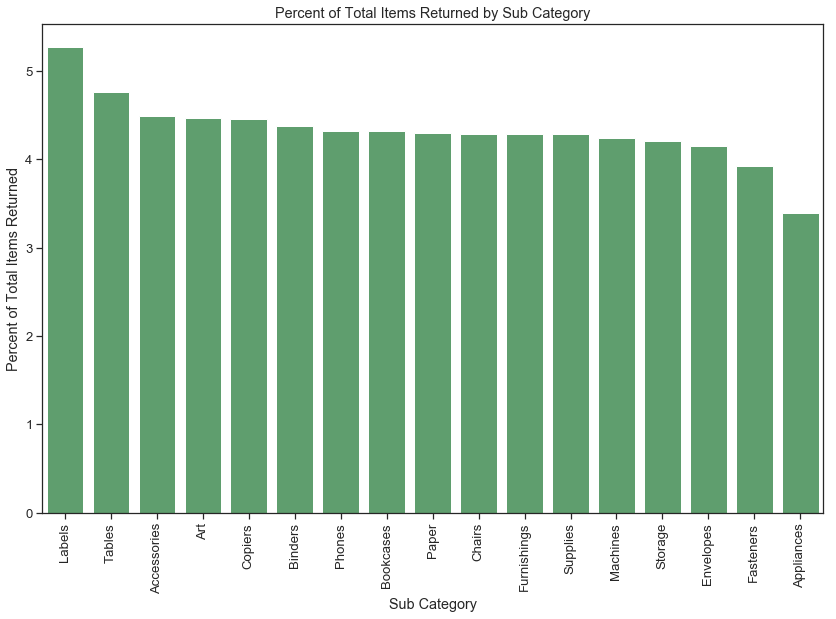

In [27]:
g3_4 = sns.barplot(x = p3_4_sub.Sub_Category, y = p3_4_sub.Pct_Returned_Sub_Cat, color='g')
g3_4.set(xlabel='Sub Category', ylabel='Percent of Total Items Returned', 
        title = "Percent of Total Items Returned by Sub Category")
g3_4.set_xticklabels(rotation=90, labels = p3_4_sub.Sub_Category)

In [28]:
p3_4_super = p3_4_sub.groupby("Category").sum()
p3_4_super = p3_4_super.rename(columns={"Returned_Orders_Sub_Cat": "Returned_Orders", 
                                         "Total_Orders_Sub_Cat": "Total_Orders"})
p3_4_super = p3_4_super[["Returned_Orders","Total_Orders"]]
p3_4_super["Pct_Total_Orders_Returned"] = p3_4_super.Returned_Orders / p3_4_super.Total_Orders * 100
p3_4_super

,Returned_Orders,Total_Orders,Pct_Total_Orders_Returned
Category,,,
Furniture,427,9860,4.330629
Office Supplies,1348,31289,4.308223
Technology,445,10141,4.388127


[Text(0,0,'Furniture'), Text(0,0,'Office Supplies'), Text(0,0,'Technology')]

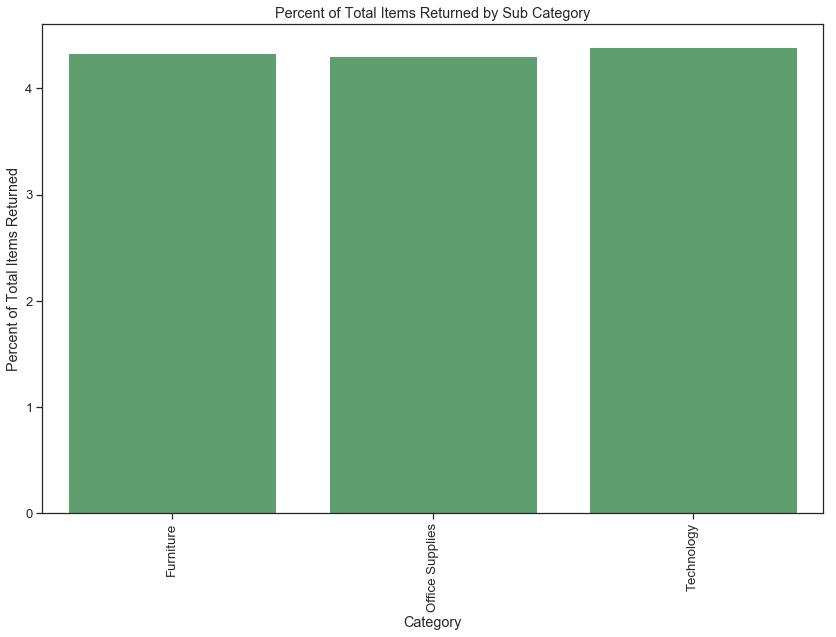

In [30]:
g3_4_super = sns.barplot(x = p3_4_super.index, y = p3_4_super.Pct_Total_Orders_Returned, color='g')
g3_4_super.set(xlabel='Category', ylabel='Percent of Total Items Returned', 
        title = "Percent of Total Items Returned by Sub Category")
g3_4_super.set_xticklabels(rotation=90, labels = p3_4_super.index)

# Part II
## Problem 4
### Step 1: Create the dependent variable

* First of all, we need to generate a categorical variable which indicates whether an order has been returned or not.
* **Hint:** the returned orders’ IDs are contained in the dataset “returns”

In [52]:
merged[["Order_ID","Returned"]].groupby("Returned").count()

,Order_ID
Returned,
No,49070
Yes,2220


### Step 2:
* Your manager believes that how long it took the order to ship would affect whether the customer would return it or not.
* He wants you to generate a feature which can measure how long it takes the company to process each order.
* **Hint** Process.Time = Ship.Date - Order.Date

In [153]:
merged.Ship_Date = pd.to_datetime(merged.Ship_Date)
merged['Process_Time'] = merged.Ship_Date - merged.Order_Date
merged['Process_Time'] = merged.Process_Time.apply(lambda d: d.days)
# check that it worked
# merged.Process_Time[:5]

0    2
1    2
2    1
3    2
4    1
Name: Process_Time, dtype: int64

### Step 3:
* If a product has been returned before, it may be returned again.
* Let us generate a feature indictes how many times the product has been returned before.
* If it never got returned, we just impute using 0.
* **Hint:** Group by different Product.ID

In [154]:
ret_prod = merged[["Product_ID","Returned","Order_ID"]].groupby(["Product_ID","Returned"]).count()
ret_prod = ret_prod.reset_index(level=["Returned"])
ret_prod = ret_prod.reset_index(level=["Product_ID"])
ret_prod = ret_prod[ret_prod.Returned == "Yes"]
ret_prod = ret_prod.rename(columns = {"Order_ID":"Return_Count"})
ret_prod = ret_prod[['Product_ID','Return_Count']]
ret_prod.head(10)

,Product_ID,Return_Count
3,FUR-BO-3176,1
7,FUR-BO-3615,1
9,FUR-BO-3616,1
13,FUR-BO-3621,1
16,FUR-BO-3624,2
18,FUR-BO-3625,2
21,FUR-BO-3627,1
23,FUR-BO-3628,1
25,FUR-BO-3629,2
27,FUR-BO-3630,1


In [155]:
# left join the return counts with the merged data set
merged_part4 = merged.merge(ret_prod, on="Product_ID", how = "left")

# replace nan with 0
merged_part4.Return_Count = merged_part4.Return_Count.replace(np.nan,0,regex=True)

# check it
# merged_part4[merged_part4.Product_ID=="FUR-BO-3629"]["Return_Count"].head()

967     2.0
5031    2.0
5172    2.0
5224    2.0
7168    2.0
Name: Return_Count, dtype: float64

## Problem 5: Fitting Models
* You can use any binary classification method you have learned so far.
* Use 80/20 training and test splits to build your model.
* Double check the column types before you fit the model.
* Only include useful features. i.e all the IDs should be excluded from your training set.
* Not that there are only less than 5% of the orders have been returned, so you should consider using the createDataPartition function from caret package that does a stratified random split of the data. Scikit-learn also has a StratifiedKfold function that does similar thing.
* Do forget to set.seed() before the spilt to make your result reproducible.
* **Note:** We are not looking for the best tuned model in the lab so don't spend too much time on grid search. Focus on model evaluation and the business use case of each model.

In [156]:
# Check column types
merged_part4.dtypes

Row_ID                     int64
Order_ID                  object
Order_Date        datetime64[ns]
Ship_Date         datetime64[ns]
Ship_Mode                 object
Customer_ID               object
Customer_Name             object
Segment                   object
Postal_Code              float64
City                      object
State                     object
Country                   object
Region                    object
Market                    object
Product_ID                object
Category                  object
Sub_Category              object
Product_Name              object
Sales                    float64
Quantity                   int64
Discount                 float64
Profit                   float64
Shipping_Cost            float64
Order_Priority            object
Returned                  object
Year                       int64
Process_Time               int64
Return_Count             float64
dtype: object

In [195]:
# Remove useless cols
for_model = merged_part4.drop(columns=["Row_ID","Order_ID","Customer_ID","Customer_Name","Product_ID","Postal_Code"])
for_model.head()

,Order_Date,Ship_Date,Ship_Mode,Segment,City,State,Country,Region,Market,Category,...,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority,Returned,Year,Process_Time,Return_Count
0,2014-11-11,2014-11-13,First Class,Consumer,Oklahoma City,Oklahoma,United States,Central US,USCA,Technology,...,221.98,2,0.0,62.15,40.77,High,No,2014,2,0.0
1,2014-02-05,2014-02-07,Second Class,Corporate,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,Furniture,...,3709.40,9,0.1,-288.77,923.63,Critical,No,2014,2,2.0
2,2014-10-17,2014-10-18,First Class,Consumer,Brisbane,Queensland,Australia,Oceania,Asia Pacific,Technology,...,5175.17,9,0.1,919.97,915.49,Medium,No,2014,1,2.0
3,2014-01-28,2014-01-30,First Class,Home Office,Berlin,Berlin,Germany,Western Europe,Europe,Technology,...,2892.51,5,0.1,-96.54,910.16,Medium,No,2014,2,0.0
4,2014-11-05,2014-11-06,Same Day,Consumer,Dakar,Dakar,Senegal,Western Africa,Africa,Technology,...,2832.96,8,0.0,311.52,903.04,Critical,No,2014,1,0.0


In [196]:
for_model.dtypes

Order_Date        datetime64[ns]
Ship_Date         datetime64[ns]
Ship_Mode                 object
Segment                   object
City                      object
State                     object
Country                   object
Region                    object
Market                    object
Category                  object
Sub_Category              object
Product_Name              object
Sales                    float64
Quantity                   int64
Discount                 float64
Profit                   float64
Shipping_Cost            float64
Order_Priority            object
Returned                  object
Year                       int64
Process_Time               int64
Return_Count             float64
dtype: object

In [197]:
# Label encoding for categorical variables
from sklearn.preprocessing import LabelEncoder

# Get all of the columns that need to be encoded
cols_to_encode = ["Ship_Mode","Segment","City","State","Country","Region","Market","Category","Sub_Category",
                  "Product_Name","Order_Priority","Returned"]
lb_encoder = LabelEncoder()

for col in cols_to_encode:
    for_model[col] = lb_encoder.fit_transform(for_model[col])

for_model.head()

,Order_Date,Ship_Date,Ship_Mode,Segment,City,State,Country,Region,Market,Category,...,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority,Returned,Year,Process_Time,Return_Count
0,2014-11-11,2014-11-13,0,0,2368,754,156,5,4,2,...,221.98,2,0.0,62.15,40.77,1,0,2014,2,0.0
1,2014-02-05,2014-02-07,2,1,3532,709,6,12,1,0,...,3709.40,9,0.1,-288.77,923.63,0,0,2014,2,2.0
2,2014-10-17,2014-10-18,0,0,499,828,6,12,1,2,...,5175.17,9,0.1,919.97,915.49,3,0,2014,1,2.0
3,2014-01-28,2014-01-30,0,2,376,149,54,21,2,2,...,2892.51,5,0.1,-96.54,910.16,3,0,2014,2,0.0
4,2014-11-05,2014-11-06,1,0,859,277,124,19,0,2,...,2832.96,8,0.0,311.52,903.04,0,0,2014,1,0.0


In [191]:
# convert dates to ordinal?
for_model.Order_Date = for_model.Order_Date.apply(dt.datetime.toordinal)
for_model.Ship_Date = for_model.Ship_Date.apply(dt.datetime.toordinal)
for_model.dtypes

Order_Date          int64
Ship_Date           int64
Ship_Mode           int64
Segment             int64
Postal_Code       float64
City                int64
State               int64
Country             int64
Region              int64
Market              int64
Category            int64
Sub_Category        int64
Product_Name        int64
Sales             float64
Quantity            int64
Discount          float64
Profit            float64
Shipping_Cost     float64
Order_Priority      int64
Returned            int64
Year                int64
Process_Time        int64
Return_Count      float64
dtype: object

In [198]:
# set seed
np.random.seed(7)

# Create a training and test set with an 80-20 split
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(for_model.drop('Returned', axis=1), 
                                                    for_model['Returned'], test_size = .2)
# Confirm the training set is the right size
# X_train_80.shape[0] / for_model.shape[0]

In [199]:
# Let's start with a logistic regression
logit_1 = linear_model.LogisticRegression()

In [200]:
logit_1.set_params(C=1e4)                  # set C high to avoid ridge regression
logit_1.fit(X_train_80, y_train_80)
print([logit_1.coef_, logit_1.intercept_])

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
# Cross validation
from sklearn.model_selection import StratifiedKFold
X = for_model.drop('Returned', axis=1)
y = for_model['Returned']
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X,y)
# confirm we now have 5 sets of training and test data with 80-20 split each
# lis = [test_index for train_index, test_index in skf.split(X, y)]
# for i in lis:
#     print(len(i)/for_model.shape[0])

## Problem 6: Evaluating Models
* What is the best metric to evaluate your model. Is accuracy good for this case?
* Now you have multiple models, which one would you pick?
* Can you get any clue from the confusion matrix? What is the meaning of precision and recall in this case? Which one do you care the most? How will your model help the manager make decisions?
* **Note:** The last question is open-ended. Your answer could be completely different depending on your understanding of this business problem.

## Problem 7: Feature Engineering Revisit
* Is there anything wrong with the new feature we generated? How should we fix it?
* **Hint:** For the real test set, we do not know it will get returned or not.